In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from scipy.stats import chi2_contingency
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, confusion_matrix, plot_confusion_matrix

pd.set_option('display.float_format', lambda x: f'{x:,.3f}')

In [2]:
# Data files should be in a folder named 'datasets' in the same directory as this file 
# If that's not the case, then the following command needs to be changed
dir_name = 'datasets'
accepted_path = os.path.join(os.getcwd(), dir_name, 'accepted.csv')
rejected_path = os.path.join(os.getcwd(), dir_name, 'rejected.csv')

# Read the data into pandas dataframes
accepted = pd.read_csv(accepted_path, delimiter = ',', low_memory = False) #better to set dtype but needs manual work
rejected = pd.read_csv(rejected_path, delimiter = ',')

In [3]:
accepted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [4]:
accepted.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,nan,"3,600.000","3,600.000","3,600.000",36 months,13.990,123.030,C,C4,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
1,68355089,nan,"24,700.000","24,700.000","24,700.000",36 months,11.990,820.280,C,C1,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
2,68341763,nan,"20,000.000","20,000.000","20,000.000",60 months,10.780,432.660,B,B4,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
3,66310712,nan,"35,000.000","35,000.000","35,000.000",60 months,14.850,829.900,C,C5,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
4,68476807,nan,"10,400.000","10,400.000","10,400.000",60 months,22.450,289.910,F,F1,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan


In [5]:
rejected.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,"1,000.000",2007-05-26,Wedding Covered but No Honeymoon,693.000,10%,481xx,NM,4 years,0.000
1,"1,000.000",2007-05-26,Consolidating Debt,703.000,10%,010xx,MA,< 1 year,0.000
2,"11,000.000",2007-05-27,Want to consolidate my debt,715.000,10%,212xx,MD,1 year,0.000
3,"6,000.000",2007-05-27,waksman,698.000,38.64%,017xx,MA,< 1 year,0.000
4,"1,500.000",2007-05-27,mdrigo,509.000,9.43%,209xx,MD,< 1 year,0.000


Text(0.5, 1.0, 'Loan Distribution by Term')

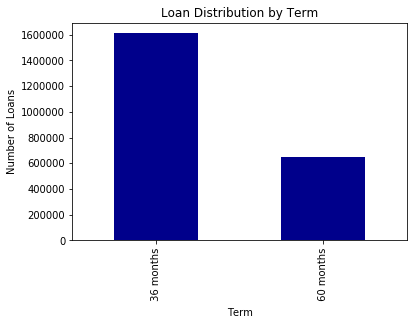

In [6]:
# make some plots to visualise the data and get a better idea of it 
accepted['term'].value_counts().plot.bar(color='darkblue')
plt.xlabel('Term')
plt.ylabel('Number of Loans')
plt.title('Loan Distribution by Term')

In [7]:
# Target Variable
target_col = 'loan_status'
target = accepted[target_col]
# explore the unique values in loan_status column
target.value_counts(dropna=False)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: loan_status, dtype: int64

Text(0.5, 1.0, 'Loans Status Distribution')

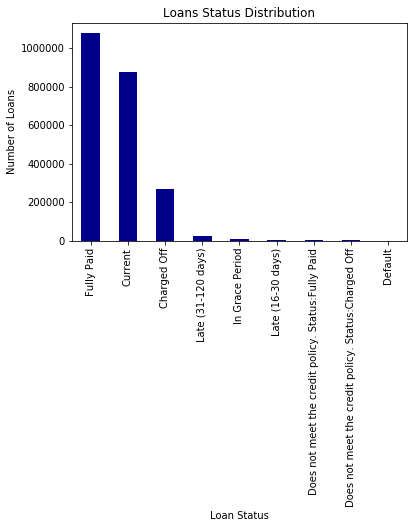

In [8]:
accepted[target_col].value_counts().plot.bar(color='darkblue')
plt.xlabel('Loan Status')
plt.ylabel('Number of Loans')
plt.title('Loans Status Distribution')
#todo check by year, maybe oldest ones don't have so many current 

In [9]:
target_col = 'loan_status'
# looking only at loans that have had an outcome:
target_status = ['Fully Paid', 'Charged Off']
accepted_with_outcome = accepted[accepted[target_col].isin(target_status)]
# model it as a binary outcome, where 1 = bad and 0 = good (in general, 1 = event and we consider default to be our event) 
accepted_with_outcome[target_col] = (accepted_with_outcome[target_col]=='Charged Off').astype(int)
accepted_with_outcome.rename(columns={target_col: 'is_bad'}, inplace = True)
target_col = 'is_bad'

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\chris\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


Text(0.5, 1.0, 'Loans by Status (0 = Good, 1 = Bad)')

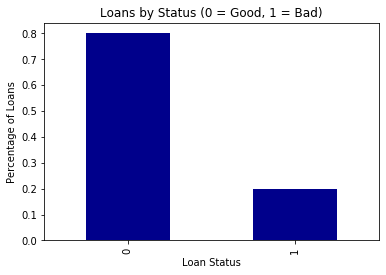

In [10]:
accepted_with_outcome[target_col].value_counts(normalize=True).plot.bar(color='darkblue')
plt.xlabel('Loan Status')
plt.ylabel('Percentage of Loans')
plt.title('Loans by Status (0 = Good, 1 = Bad)')

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Loans Issued per Year')

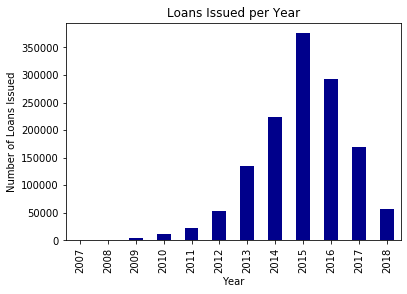

In [11]:
# explore loan issuance by date and maybe use data only from a specific year 
accepted_with_outcome['issue_d'] = pd.to_datetime(accepted_with_outcome['issue_d'])
accepted_with_outcome['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Issued')
plt.title('Loans Issued per Year')

Text(0, 0.5, 'Number of Columns')

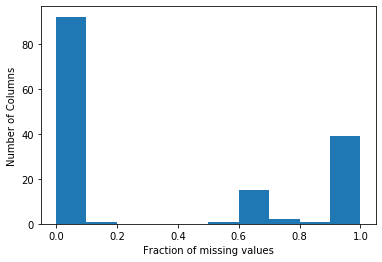

In [12]:
missing_fractions = accepted_with_outcome.isnull().mean().sort_values(ascending=False)
missing_fractions.plot.hist()
#plt.title('Fraction of missing values column distribution')
plt.xlabel('Fraction of missing values')
plt.ylabel('Number of Columns')
#todo rethink because maybe there are important columns that were added later on -> time distribution? or do that after you decide on sample period?

In [13]:
all_cols = set(accepted_with_outcome.columns)
cols2drop = set()

# columns with too many missing values
underrepresented_cols = set(missing_fractions[missing_fractions>0.5].index)
print("There are {} columns that are missing in more than 50% of the entries. These are: \n{}"
      .format(len(underrepresented_cols),underrepresented_cols))

cols2drop |=  underrepresented_cols

There are 58 columns that are missing in more than 50% of the entries. These are: 
{'open_act_il', 'sec_app_mort_acc', 'settlement_status', 'mths_since_recent_bc_dlq', 'hardship_payoff_balance_amount', 'hardship_amount', 'mths_since_last_record', 'hardship_length', 'hardship_reason', 'verification_status_joint', 'dti_joint', 'hardship_end_date', 'sec_app_collections_12_mths_ex_med', 'settlement_percentage', 'member_id', 'open_il_24m', 'hardship_type', 'inq_fi', 'open_acc_6m', 'mths_since_last_delinq', 'next_pymnt_d', 'settlement_date', 'mths_since_recent_revol_delinq', 'mths_since_rcnt_il', 'hardship_status', 'all_util', 'sec_app_inq_last_6mths', 'sec_app_num_rev_accts', 'open_rv_12m', 'inq_last_12m', 'annual_inc_joint', 'max_bal_bc', 'sec_app_open_act_il', 'il_util', 'orig_projected_additional_accrued_interest', 'hardship_start_date', 'hardship_last_payment_amount', 'sec_app_open_acc', 'deferral_term', 'revol_bal_joint', 'sec_app_revol_util', 'hardship_loan_status', 'settlement_amount

In [14]:
# explore remaining columns and evaluate them
remaining_cols = all_cols - cols2drop
print("The remaining columns (present in more than 50% of the entries) are {}:\n {}".format(len(remaining_cols), remaining_cols))

The remaining columns (present in more than 50% of the entries) are 93:
 {'issue_d', 'int_rate', 'total_rec_prncp', 'pct_tl_nvr_dlq', 'num_op_rev_tl', 'total_bc_limit', 'total_pymnt', 'total_pymnt_inv', 'num_il_tl', 'delinq_amnt', 'revol_bal', 'mort_acc', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'purpose', 'hardship_flag', 'inq_last_6mths', 'addr_state', 'id', 'mo_sin_rcnt_tl', 'pub_rec', 'total_rev_hi_lim', 'home_ownership', 'num_actv_bc_tl', 'pymnt_plan', 'bc_util', 'bc_open_to_buy', 'pub_rec_bankruptcies', 'mo_sin_rcnt_rev_tl_op', 'funded_amnt_inv', 'initial_list_status', 'acc_open_past_24mths', 'installment', 'loan_amnt', 'mths_since_recent_inq', 'tax_liens', 'num_accts_ever_120_pd', 'num_bc_tl', 'num_bc_sats', 'dti', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_credit_pull_d', 'num_tl_op_past_12m', 'earliest_cr_line', 'total_rec_late_fee', 'url', 'emp_length', 'acc_now_delinq', 'annual_inc', 'num_tl_30dpd', 'zip_code', 'num_sats', 'mths_since_recent_bc', 'term', 'total_ac

In [15]:
irrelevant_cols = set(['id', 'url'])
cols2drop |=  irrelevant_cols

forward_looking_cols = set(['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
             'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
             'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high',
             'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code',  
             'debt_settlement_flag'])
cols2drop |= forward_looking_cols

In [16]:
# Drop the selected columns and examine the remaining ones
accepted_with_outcome_reduced = accepted_with_outcome.drop(labels=cols2drop, axis=1)
# examine numeric variables
accepted_with_outcome_reduced.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Columns: 71 entries, loan_amnt to disbursement_method
dtypes: datetime64[ns](1), float64(53), int32(1), object(16)
memory usage: 733.9+ MB


In [17]:
# examine categorical variables
accepted_with_outcome_reduced.describe(include='object').T

,count,unique,top,freq
term,1345310,2,36 months,1020743
grade,1345310,7,B,392741
sub_grade,1345310,35,C1,85494
emp_title,1259525,378353,Teacher,21268
emp_length,1266799,11,10+ years,442199
home_ownership,1345310,6,MORTGAGE,665579
verification_status,1345310,3,Source Verified,521273
purpose,1345310,14,debt_consolidation,780321
title,1328651,61682,Debt consolidation,660960
zip_code,1345309,943,945xx,15005


In [18]:
# We drop the categorical variables that have too many unique values and cannot be interpreted as numerical
# We also drop the 'hardship_flag' column, as it seems to take only one value and therefore can not be useful
drop = ['sub_grade', 'emp_title', 'title', 'zip_code', 'addr_state', 'hardship_flag']
accepted_with_outcome_reduced.drop(labels=drop, axis=1, inplace=True)
accepted_with_outcome_reduced.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Columns: 65 entries, loan_amnt to disbursement_method
dtypes: datetime64[ns](1), float64(53), int32(1), object(10)
memory usage: 672.3+ MB


In [19]:
# while keeping the distribution of bad loans in test set same in both sets (using stratification)
X = accepted_with_outcome_reduced.drop(target_col, axis = 1)
Y = accepted_with_outcome_reduced[target_col]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0, stratify = Y)

X_train, X_test = X_train.copy(), X_test.copy()

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(941717, 64) (403593, 64) (941717,) (403593,)


In [20]:
# functions to use for data cleaning and transformations


# create a helper function clean up the emp_length column, assign 0 to NANs, and convert to numeric
def convert_emp_length(df):    
    # turn emp_length into numeric 0 - 10 
    df['emp_length'] = df['emp_length'].replace({'< 1 year': '0 years', '10+ years': '10 years'})
    df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype('float')
    #df['emp_length'].fillna(value = 0, inplace = True)

# apply to X_train
convert_emp_length(X_train)

# Confirm our transformation
X_train['emp_length'].unique()

array([ 4., 10.,  0.,  1.,  5.,  3.,  2., nan,  6.,  9.,  7.,  8.])

In [21]:
# convert date columns to datetime format and create a new column as a difference between today and the respective date
def convert_date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('today').normalize()
    # convert to datetime format
    df[column] = pd.to_datetime(df[column])
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

# apply to X_train
convert_date_columns(X_train, 'earliest_cr_line')
convert_date_columns(X_train, 'issue_d')

# let's check these new columns
print(X_train['mths_since_earliest_cr_line'].describe())
print(X_train['mths_since_issue_d'].describe())

count   941,717.000
mean        265.955
std          91.317
min          67.000
25%         203.000
50%         249.000
75%         313.000
max         928.000
Name: mths_since_earliest_cr_line, dtype: float64
count   941,717.000
mean         70.835
std          19.422
min          29.000
25%          58.000
50%          69.000
75%          82.000
max         166.000
Name: mths_since_issue_d, dtype: float64


In [22]:
# function to convert 'term' column to numeric
def convert_loan_term(df):
    df['term'] = df['term'].str.replace(' months', '').astype('float')

convert_loan_term(X_train)
print(X_train['term'].describe())

count   941,717.000
mean         41.802
std          10.275
min          36.000
25%          36.000
50%          36.000
75%          36.000
max          60.000
Name: term, dtype: float64


In [23]:
# examine the remaining categorical features 
X_train.describe(include='object').T

,count,unique,top,freq
grade,941717,7,B,274523
home_ownership,941717,6,MORTGAGE,465514
verification_status,941717,3,Source Verified,364997
purpose,941717,14,debt_consolidation,546266
initial_list_status,941717,2,w,548535
application_type,941717,2,Individual,923796
disbursement_method,941717,2,Cash,936867


In [24]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}
X_train_cat = list(X_train.select_dtypes('object').columns)
# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(Y_train, X_train[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('Chi-square',[]).append(chi)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, inplace = True)
chi2_result

,Feature,Chi-square,p-value
0,grade,"64,594.303",0.000
1,home_ownership,"4,789.544",0.000
2,verification_status,"8,089.137",0.000
3,purpose,"2,892.730",0.000
4,initial_list_status,53.622,0.000
5,application_type,241.145,0.000
6,disbursement_method,1.192,0.275


In [25]:
# remove disbursement_method because of high p-value
all_cols2drop = [] # save here all the columns that we will eventually drop in X_train to apply to X_test later
cols2drop = ['disbursement_method']
X_train.drop(labels=cols2drop, axis=1, inplace=True)
all_cols2drop += cols2drop

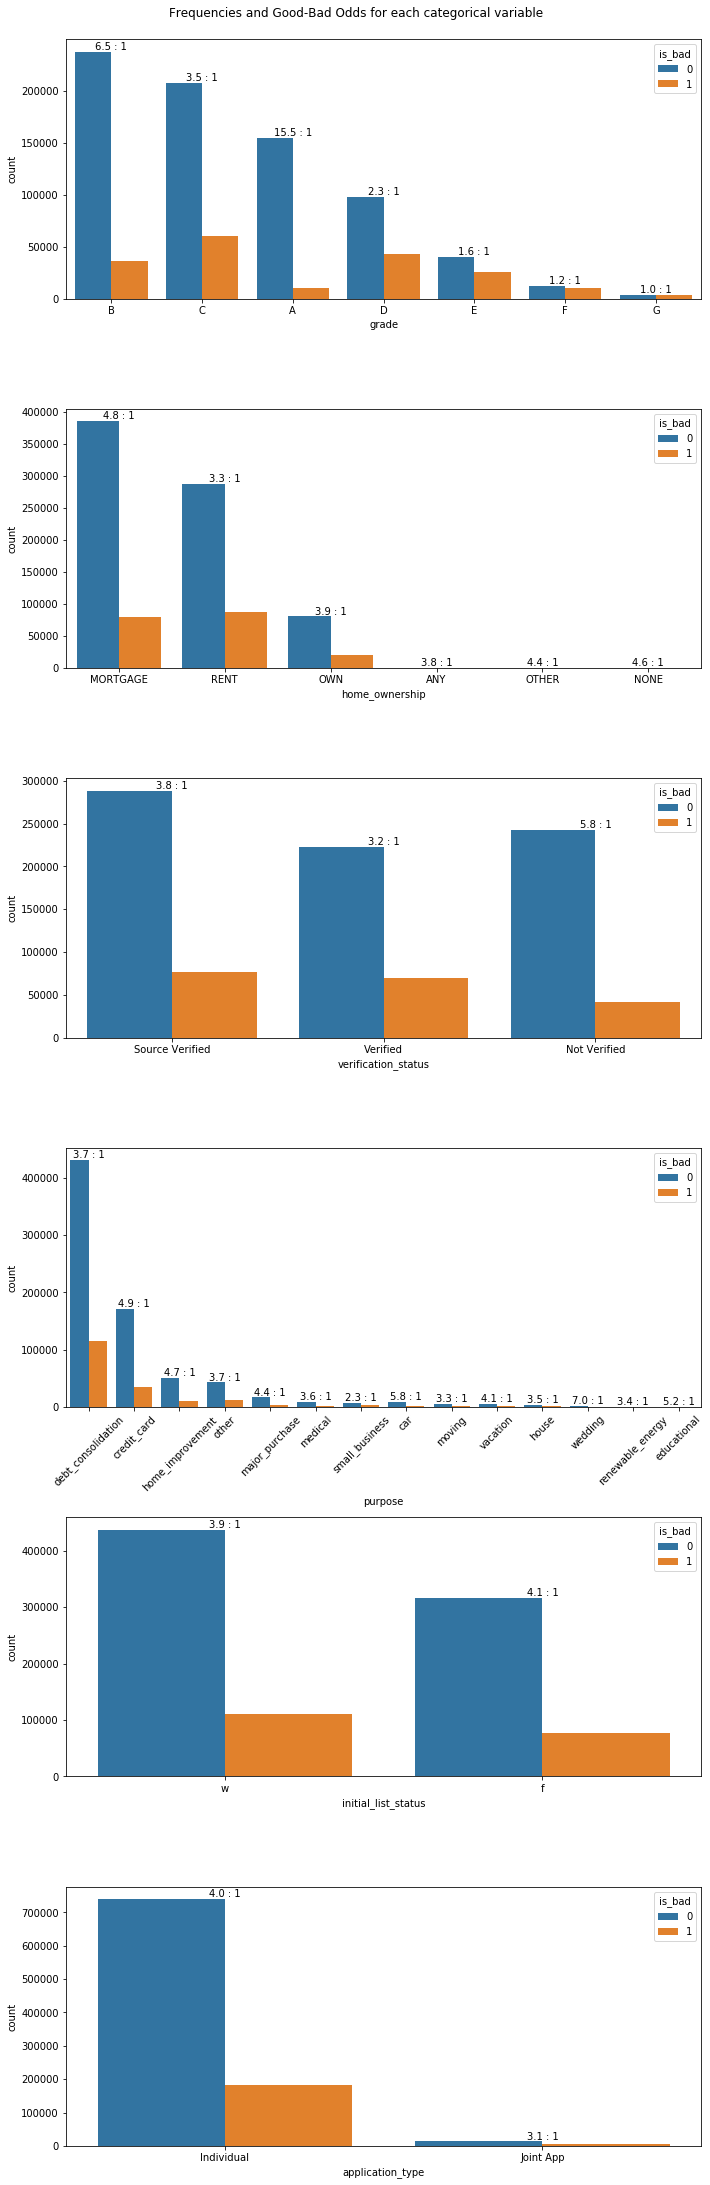

In [26]:
def add_GB_odds_to_plot(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()

def barPerc(df,xVar,ax):
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable 
        ax: Axes object (for Seaborn Countplot/Bar plot or
                         pandas bar plot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])
        frequencies = [x.get_height() for x in hueBars]
        odds = round(frequencies[0] / frequencies[1],1)

        # 3. Print the percentage on the bars
        bar = hueBars[0]
        ax.text(bar.get_x() + bar.get_width(),
                bar.get_height(),
                str(odds)+" : 1",
                ha="center",va="bottom")
        
def plot_frequencies(df, feature, target):
    order = df[feature].value_counts().index # order categories by size 
    ax = sns.countplot(x=feature, hue=target, data=df, order=order)
    barPerc(df, feature, ax)
    
# coarse classification for categorical variables 
categorical_cols = list(X_train.select_dtypes('object').columns)

n = len(categorical_cols)
fig, axs = plt.subplots(n, figsize=(10,30))
fig.suptitle("Frequencies and Good-Bad Odds for each categorical variable", y=1.01)
for i, feature in enumerate(categorical_cols):
    plt.subplot(n, 1, i+1)
    if (feature == 'purpose'):
        # We saw in the table above that the last feature takes 41 distinct
        # values, so we pivot the labels to make them fit in the figure 
        plt.xticks(rotation=45)
    plot_frequencies(X_train, feature,Y_train)
    
plt.tight_layout()


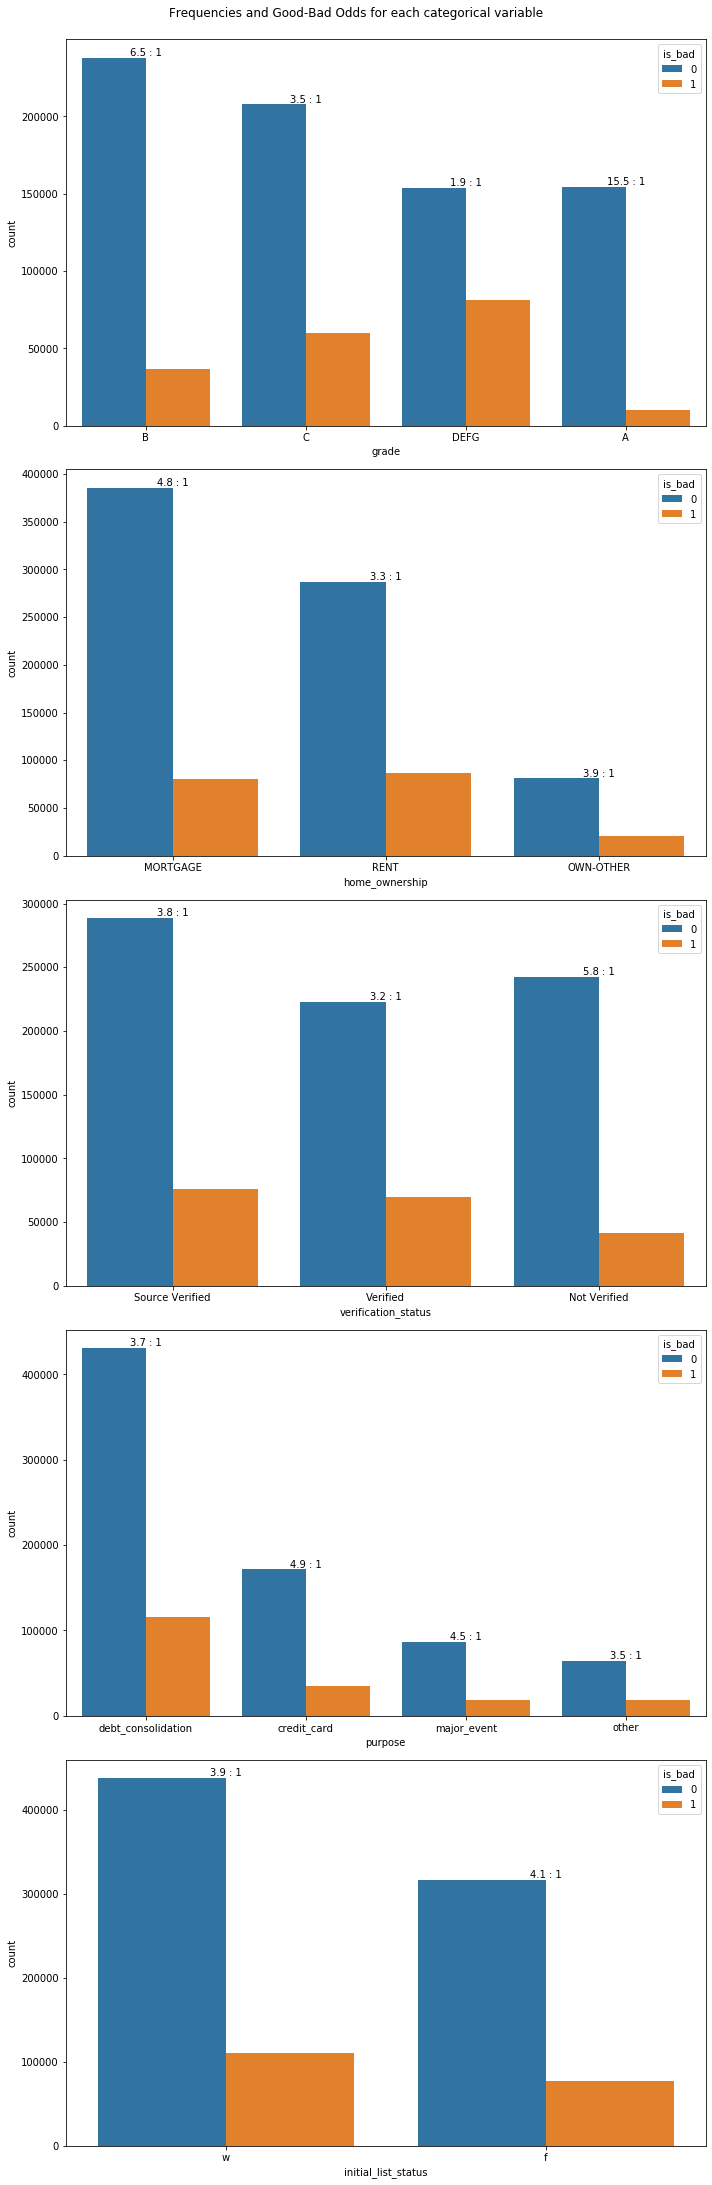

In [27]:
X_train['grade'].replace(to_replace=['D','E','F','G'], value='DEFG', inplace=True)
X_train['home_ownership'].replace(to_replace=['OWN','ANY','OTHER','NONE'], value='OWN-OTHER', inplace=True)
X_train['purpose'].replace(to_replace=['home_improvement','major_purchase','car','moving','house', 'wedding'], 
                           value='major_event', inplace=True)
X_train['purpose'].replace(to_replace=['other', 'medical', 'small_business', 'vacation', 'renewable_energy', 'educational'], 
                           value='other', inplace=True)

cols2drop = ['application_type']
X_train.drop(labels=cols2drop, axis=1, inplace=True)
all_cols2drop += cols2drop

# Examine our results
categorical_cols = list(X_train.select_dtypes('object').columns)

n = len(categorical_cols)
fig, axs = plt.subplots(n, figsize=(10,30))
fig.suptitle("Frequencies and Good-Bad Odds for each categorical variable", y=1.01)
for i, feature in enumerate(categorical_cols):
    plt.subplot(n, 1, i+1)
    plot_frequencies(X_train, feature,Y_train)
    
plt.tight_layout()

In [28]:
X_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941717 entries, 879465 to 1788769
Columns: 62 entries, loan_amnt to mths_since_issue_d
dtypes: float64(57), object(5)
memory usage: 492.6+ MB


The following 32 columns should be dropped because of high correlation with other columns: 
['installment', 'fico_range_high', 'total_acc', 'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'mths_since_earliest_cr_line']


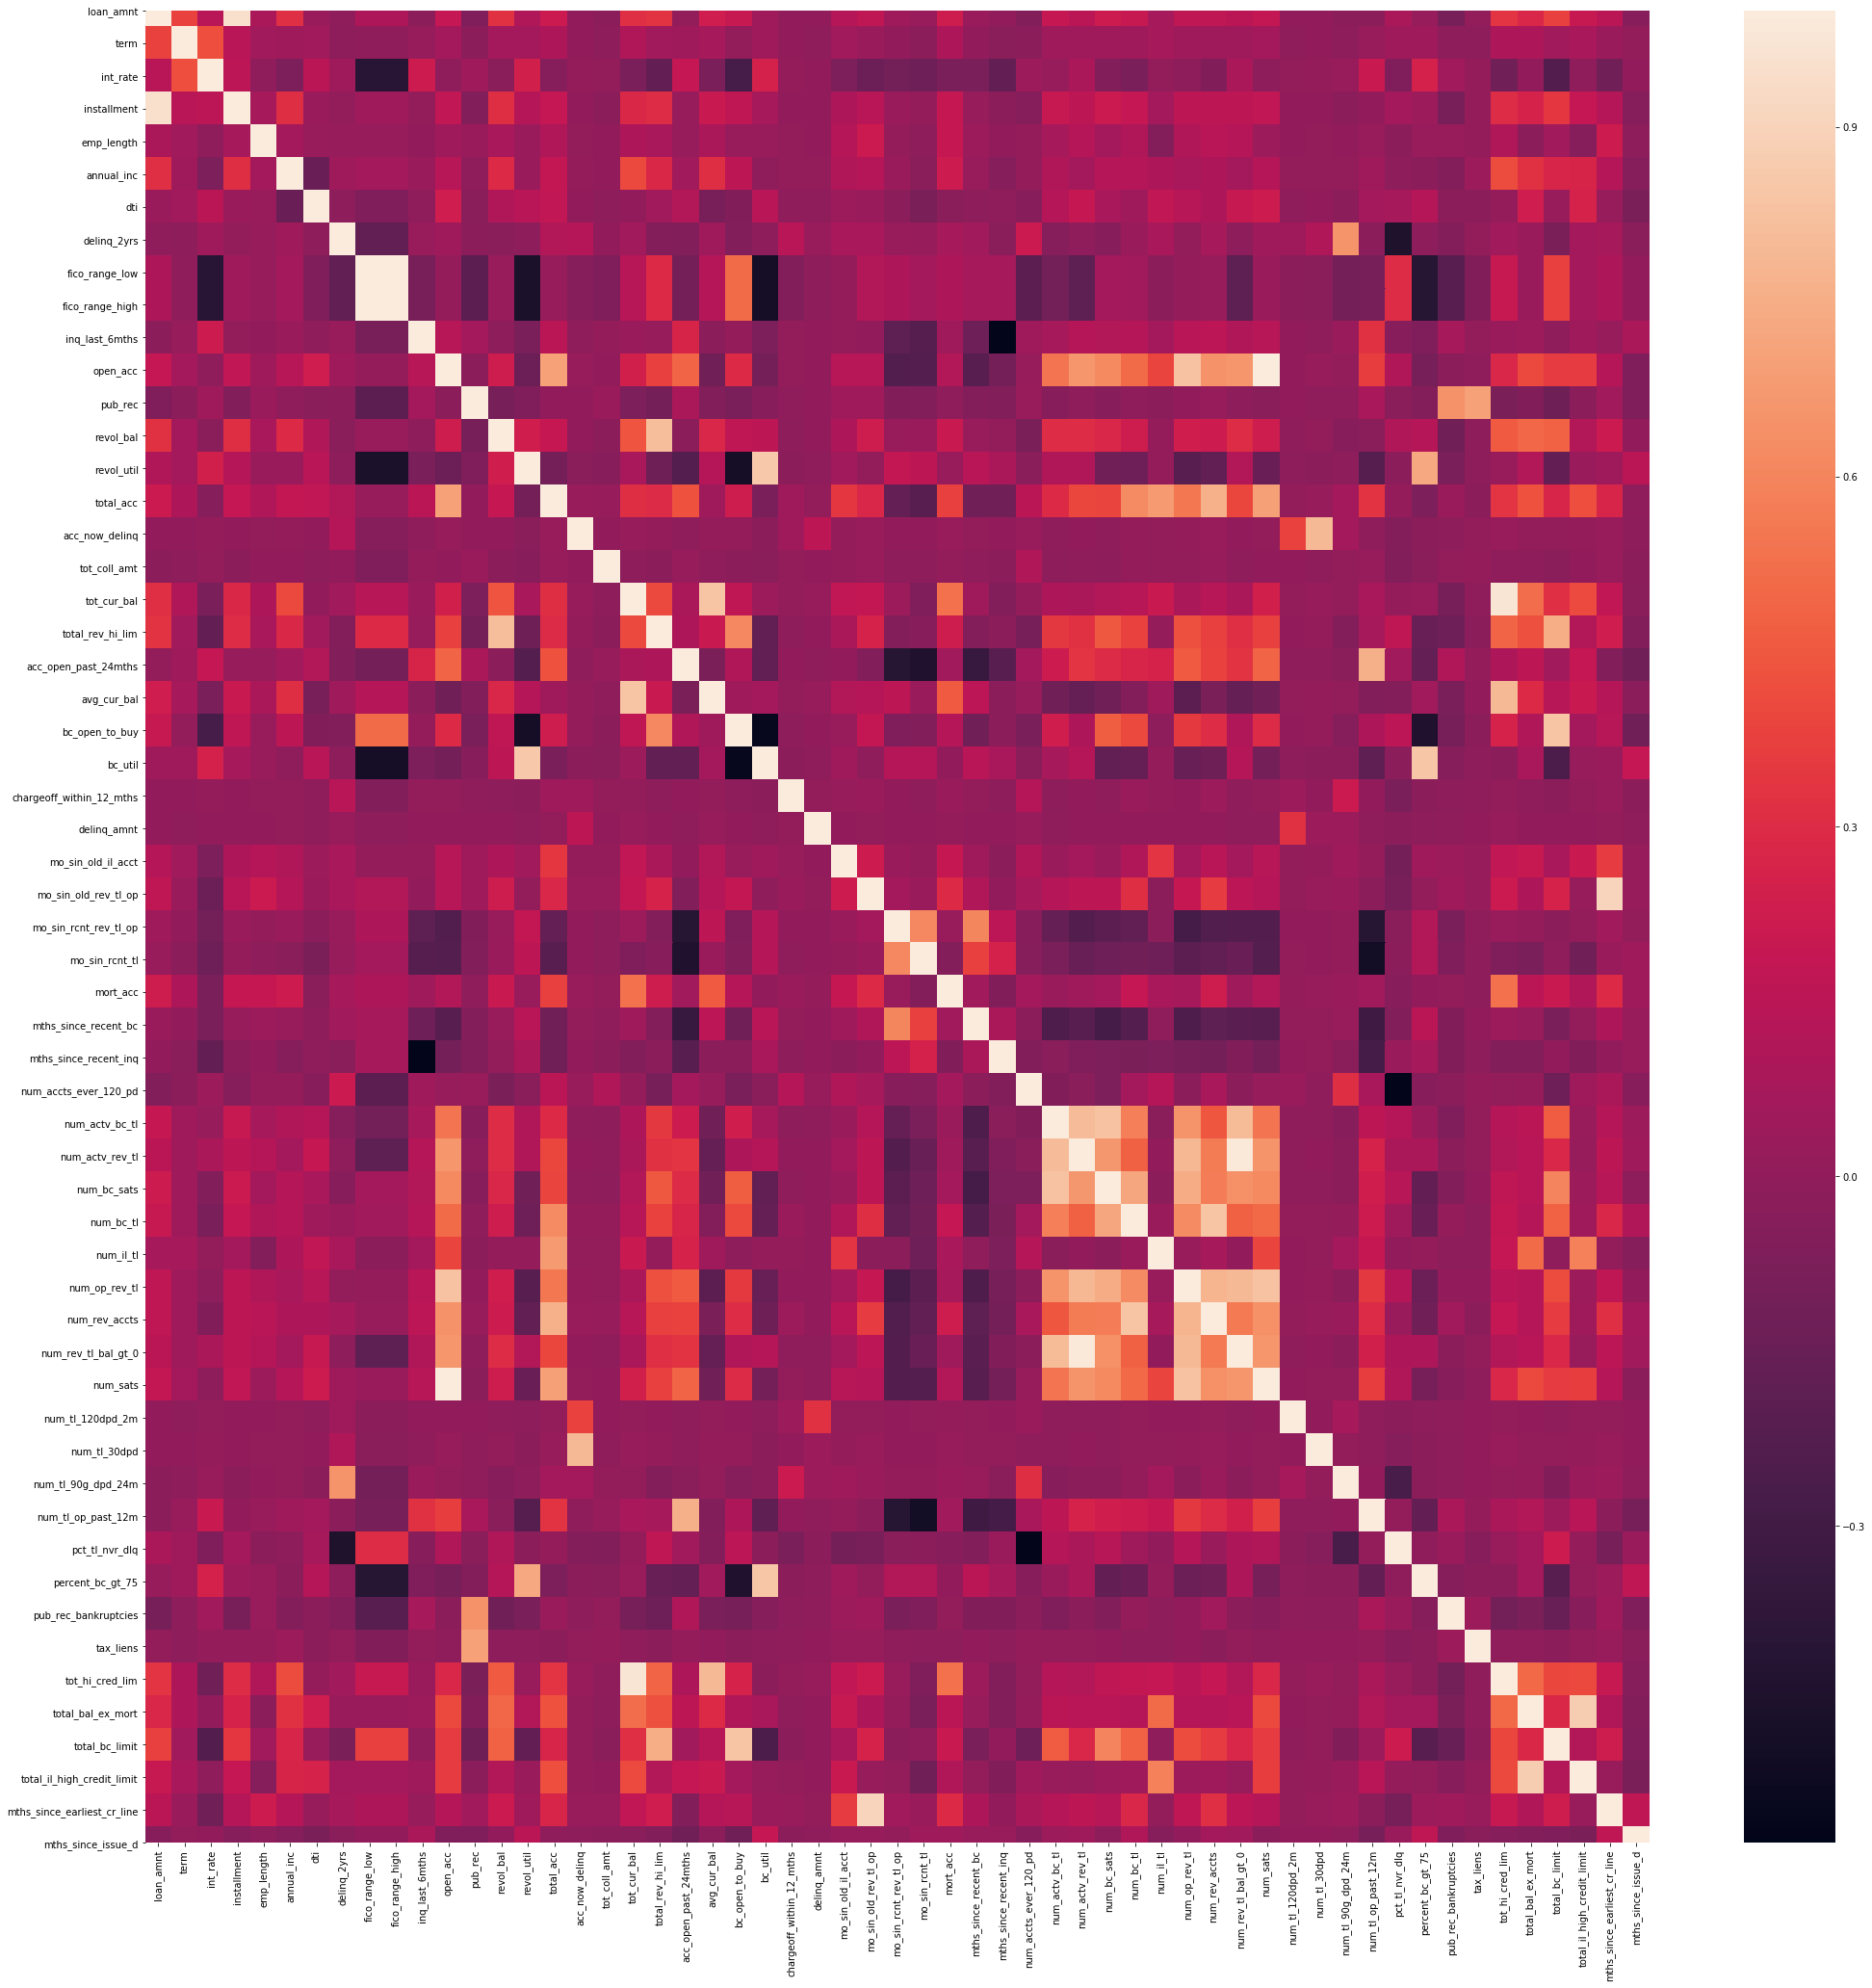

In [29]:
numeric_cols = list(X_train.select_dtypes('float').columns)
# calculate pair-wise correlations between the features
corrmat = X_train[numeric_cols].corr()
upper_tri = corrmat.where(np.triu(np.ones(corrmat.shape),k=1).astype(np.bool))

cols2drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > 0.5)] 
print("The following {} columns should be dropped because of high correlation with other columns: \n{}"
      .format(len(cols2drop),cols2drop))
# visualise to confirm results
plt.figure(figsize=(35,35))
sns.heatmap(corrmat);

In [30]:
# drop correlated columns
X_train.drop(labels=cols2drop, axis=1, inplace=True)
all_cols2drop += cols2drop

X_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941717 entries, 879465 to 1788769
Columns: 30 entries, loan_amnt to mths_since_issue_d
dtypes: float64(25), object(5)
memory usage: 262.7+ MB


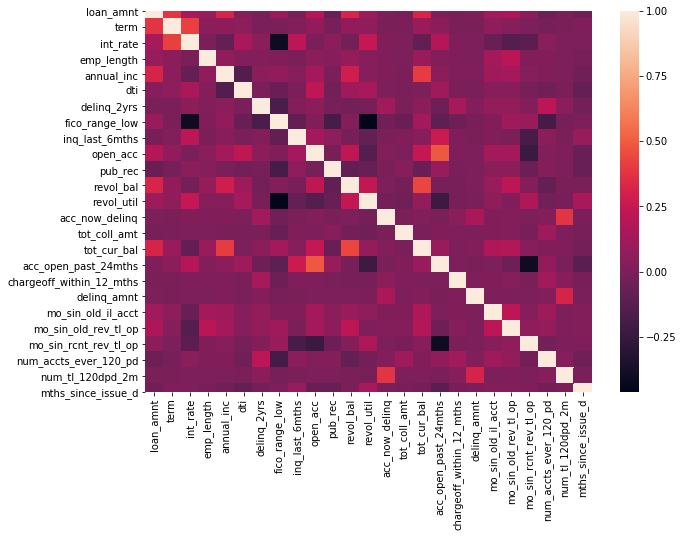

In [31]:
numeric_cols = list(X_train.select_dtypes('float').columns)
# calculate pair-wise correlations between the features
corrmat = X_train[numeric_cols].corr()
# visualise to confirm lack of correlation in the remaining variables
plt.figure(figsize=(10,7))
sns.heatmap(corrmat);

In [32]:
# Create a copy of X_train to use for determining how to coarse classify the numerica variables
X_train_copy = X_train.copy()

# split each numeric variable into 10 equal-sized groups (fine classes), 
# calclulate Good:Bad Odds and group the ones with similar odds together 
# Note that missing values will end up in a separate (11th) group
for col in numeric_cols:
    #if (len(X_train[col].unique()) > 10):
    X_train_copy[col] = pd.qcut(X_train_copy[col], 10, duplicates='drop').cat.add_categories("missing").fillna("missing")
    display((pd.crosstab(X_train_copy[col],Y_train)).assign(GB_odds=lambda dfx: (dfx[0] / dfx[1])))

is_bad,0,1,GB_odds
loan_amnt,,,
"(499.999, 5000.0]",107202,20109,5.331
"(5000.0, 6500.0]",52584,9910,5.306
"(6500.0, 8675.0]",77068,15694,4.911
"(8675.0, 10000.0]",87113,19350,4.502
"(10000.0, 12000.0]",71535,18382,3.892
"(12000.0, 15000.0]",85622,22780,3.759
"(15000.0, 18000.0]",61943,18218,3.400
"(18000.0, 21000.0]",67555,19888,3.397
"(21000.0, 28000.0]",79847,23156,3.448


is_bad,0,1,GB_odds
term,,,
"(35.999, 60.0]",753726,187991,4.009


is_bad,0,1,GB_odds
int_rate,,,
"(5.308999999999999, 7.39]",90211,4660,19.359
"(7.39, 8.9]",86917,8121,10.703
"(8.9, 10.49]",84708,11652,7.270
"(10.49, 11.53]",79810,14489,5.508
"(11.53, 12.74]",76720,16064,4.776
"(12.74, 13.98]",73561,18590,3.957
"(13.98, 15.22]",72445,22016,3.291
"(15.22, 16.99]",71088,26058,2.728
"(16.99, 19.52]",64404,30195,2.133


is_bad,0,1,GB_odds
emp_length,,,
"(-0.001, 1.0]",109403,28239,3.874
"(1.0, 2.0]",68423,16975,4.031
"(2.0, 3.0]",60170,15014,4.008
"(3.0, 5.0]",92580,22705,4.078
"(5.0, 6.0]",35711,8521,4.191
"(6.0, 8.0]",67342,16600,4.057
"(8.0, 10.0]",279944,65123,4.299
missing,40153,14814,2.710


is_bad,0,1,GB_odds
annual_inc,,,
"(-0.001, 34000.0]",72177,22898,3.152
"(34000.0, 42000.0]",75230,22396,3.359
"(42000.0, 50000.0]",86092,24154,3.564
"(50000.0, 57000.0]",61031,16327,3.738
"(57000.0, 65000.0]",86131,22534,3.822
"(65000.0, 74000.0]",62122,15004,4.140
"(74000.0, 85000.0]",86310,20386,4.234
"(85000.0, 100000.0]",77293,16741,4.617
"(100000.0, 125000.0]",68971,13646,5.054


is_bad,0,1,GB_odds
dti,,,
"(-1.001, 7.27]",80334,13883,5.787
"(7.27, 10.49]",79816,14274,5.592
"(10.49, 13.02]",79157,15243,5.193
"(13.02, 15.32]",77655,16233,4.784
"(15.32, 17.61]",76837,17371,4.423
"(17.61, 19.99]",75679,18642,4.060
"(19.99, 22.6]",74167,19921,3.723
"(22.6, 25.69]",72745,21362,3.405
"(25.69, 29.78]",70486,23645,2.981


is_bad,0,1,GB_odds
delinq_2yrs,,,
"(-0.001, 1.0]",706712,174214,4.057
"(1.0, 30.0]",47014,13777,3.412


is_bad,0,1,GB_odds
fico_range_low,,,
"(624.999, 665.0]",122658,43791,2.801
"(665.0, 670.0]",61703,20214,3.052
"(670.0, 675.0]",55731,17405,3.202
"(675.0, 680.0]",55617,16751,3.320
"(680.0, 690.0]",98747,26474,3.730
"(690.0, 695.0]",44376,10996,4.036
"(695.0, 705.0]",79005,17688,4.467
"(705.0, 720.0]",89681,16392,5.471
"(720.0, 740.0]",67357,10194,6.608


is_bad,0,1,GB_odds
inq_last_6mths,,,
"(-0.001, 1.0]",644292,151519,4.252
"(1.0, 2.0]",72688,23047,3.154
"(2.0, 8.0]",36745,13425,2.737
missing,1,0,inf


is_bad,0,1,GB_odds
open_acc,,,
"(-0.001, 6.0]",117951,26601,4.434
"(6.0, 7.0]",58691,13517,4.342
"(7.0, 8.0]",65022,15252,4.263
"(8.0, 9.0]",67394,16185,4.164
"(9.0, 11.0]",125073,31336,3.991
"(11.0, 12.0]",53839,13691,3.932
"(12.0, 13.0]",46531,12010,3.874
"(13.0, 15.0]",73080,19070,3.832
"(15.0, 19.0]",84999,22526,3.773


is_bad,0,1,GB_odds
pub_rec,,,
"(-0.001, 1.0]",733859,181882,4.035
"(1.0, 86.0]",19867,6109,3.252


is_bad,0,1,GB_odds
revol_bal,,,
"(-0.001, 3016.0]",75585,18618,4.060
"(3016.0, 5012.0]",75601,18561,4.073
"(5012.0, 6878.0]",75480,18705,4.035
"(6878.0, 8873.0]",74967,19211,3.902
"(8873.0, 11141.0]",74983,19175,3.910
"(11141.0, 13859.0]",74563,19590,3.806
"(13859.0, 17405.0]",74477,19695,3.782
"(17405.0, 22700.0]",74602,19568,3.812
"(22700.0, 32395.0]",75765,18400,4.118


is_bad,0,1,GB_odds
revol_util,,,
"(-0.001, 18.1]",80140,13986,5.730
"(18.1, 29.0]",78399,15810,4.959
"(29.0, 37.4]",77102,17292,4.459
"(37.4, 45.0]",76334,18537,4.118
"(45.0, 52.2]",74796,19149,3.906
"(52.2, 59.3]",74332,19898,3.736
"(59.3, 66.8]",73716,20208,3.648
"(66.8, 75.0]",73316,20605,3.558
"(75.0, 85.0]",72825,20882,3.487


is_bad,0,1,GB_odds
acc_now_delinq,,,
"(-0.001, 14.0]",753726,187991,4.009


is_bad,0,1,GB_odds
tot_coll_amt,,,
"(-0.001, 211.0]",644196,160837,4.005
"(211.0, 932461.0]",69527,19858,3.501
missing,40003,7296,5.483


is_bad,0,1,GB_odds
tot_cur_bal,,,
"(-0.001, 14078.0]",70864,18579,3.814
"(14078.0, 24172.0]",69405,20041,3.463
"(24172.0, 35302.0]",68517,20925,3.274
"(35302.0, 50920.0]",67894,21546,3.151
"(50920.0, 80213.0]",68129,21311,3.197
"(80213.0, 129593.0]",70671,18770,3.765
"(129593.0, 182005.0]",72666,16775,4.332
"(182005.0, 244004.6]",73913,15528,4.760
"(244004.6, 340761.0]",75092,14351,5.233


is_bad,0,1,GB_odds
acc_open_past_24mths,,,
"(-0.001, 1.0]",101259,17321,5.846
"(1.0, 2.0]",98897,19114,5.174
"(2.0, 3.0]",109563,23734,4.616
"(3.0, 4.0]",102576,24964,4.109
"(4.0, 5.0]",87286,22791,3.830
"(5.0, 6.0]",67800,19701,3.441
"(6.0, 7.0]",50235,15541,3.232
"(7.0, 9.0]",59211,20262,2.922
"(9.0, 64.0]",48601,19714,2.465


is_bad,0,1,GB_odds
chargeoff_within_12_mths,,,
"(-0.001, 10.0]",753690,187986,4.009
missing,36,5,7.200


is_bad,0,1,GB_odds
delinq_amnt,,,
"(-0.001, 249925.0]",753726,187991,4.009


is_bad,0,1,GB_odds
mo_sin_old_il_acct,,,
"(-0.001, 53.0]",67444,21144,3.190
"(53.0, 86.0]",69082,18358,3.763
"(86.0, 108.0]",71020,18150,3.913
"(108.0, 121.0]",69310,17909,3.870
"(121.0, 129.0]",67508,17016,3.967
"(129.0, 138.0]",73980,17713,4.177
"(138.0, 147.0]",66857,15559,4.297
"(147.0, 159.0]",70071,16221,4.320
"(159.0, 180.0]",68232,15848,4.305


is_bad,0,1,GB_odds
mo_sin_old_rev_tl_op,,,
"(1.999, 76.0]",67204,23586,2.849
"(76.0, 107.0]",71797,20114,3.570
"(107.0, 126.0]",66987,19051,3.516
"(126.0, 144.0]",70453,18691,3.769
"(144.0, 164.0]",73355,18149,4.042
"(164.0, 186.0]",73007,17166,4.253
"(186.0, 213.0]",71016,16578,4.284
"(213.0, 250.0]",73073,16245,4.498
"(250.0, 312.0]",73606,15607,4.716


is_bad,0,1,GB_odds
mo_sin_rcnt_rev_tl_op,,,
"(-0.001, 2.0]",112048,34916,3.209
"(2.0, 3.0]",54124,15430,3.508
"(3.0, 4.0]",49118,13467,3.647
"(4.0, 6.0]",83528,22186,3.765
"(6.0, 8.0]",68328,17861,3.826
"(8.0, 10.0]",54859,13790,3.978
"(10.0, 14.0]",83974,20858,4.026
"(14.0, 19.0]",64131,14861,4.315
"(19.0, 30.0]",71272,14716,4.843


is_bad,0,1,GB_odds
num_accts_ever_120_pd,,,
"(-0.001, 1.0]",635878,159831,3.978
"(1.0, 2.0]",35723,9757,3.661
"(2.0, 51.0]",42122,11107,3.792
missing,40003,7296,5.483


is_bad,0,1,GB_odds
num_tl_120dpd_2m,,,
"(-0.001, 4.0]",688349,171240,4.020
missing,65377,16751,3.903


is_bad,0,1,GB_odds
mths_since_issue_d,,,
"(28.999, 47.0]",83544,21184,3.944
"(47.0, 55.0]",71332,22112,3.226
"(55.0, 61.0]",64363,22147,2.906
"(61.0, 65.0]",84242,21612,3.898
"(65.0, 69.0]",74274,18256,4.068
"(69.0, 73.0]",70665,18140,3.896
"(73.0, 79.0]",81625,20132,4.054
"(79.0, 86.0]",70754,16058,4.406
"(86.0, 96.0]",78773,14789,5.326


In [33]:
# Remove the columns with only one category (it means that more than 90% of the entries have the same value)
cols2drop = ['acc_now_delinq', 'delinq_amnt', 'chargeoff_within_12_mths', 'num_tl_120dpd_2m']
X_train.drop(labels=cols2drop, axis=1, inplace=True)
all_cols2drop += cols2drop

In [34]:
def convert_to_interval(df):
    
    bins = {
    'loan_amnt' : pd.IntervalIndex.from_tuples([(499.999, 8675.0), (8675.0, 15000.0), (15000.0, 40000.0)]),
    'int_rate' : pd.IntervalIndex.from_tuples([(5.308, 7.39), (7.39, 12.74), (12.74, 30.99)]),
    'emp_length' : pd.IntervalIndex.from_tuples([(-0.001, 1.0), (1.0, 10.0)]),
    'annual_inc' : pd.IntervalIndex.from_tuples([(-0.001, 65000), (65000, 100000), (100000, 10999200)]),     
    'dti' : pd.IntervalIndex.from_tuples([(-1.001, 13.02), (13.02, 19.99), (19.99, 25.69), (25.69, 999.0)]),
    'delinq_2yrs' : pd.IntervalIndex.from_tuples([(-0.001, 1.0), (1.0, 30.0)]),
    'fico_range_low' : pd.IntervalIndex.from_tuples([(624.999, 690.0), (690.0, 705.0), (705.0, 740.0), (740.0, 845.0)]),
    'inq_last_6mths' : pd.IntervalIndex.from_tuples([(-0.001, 1.0), (1.0, 2.0), (2.0, 8.0)]),
    'open_acc' : pd.IntervalIndex.from_tuples([(-0.001, 9.0), (9.0, 90.0)]),
    'pub_rec' : pd.IntervalIndex.from_tuples([(-0.001, 1.0), (1.0, 86.0)]),
    'revol_bal' : pd.IntervalIndex.from_tuples([(-0.001,  6878.0), ( 6878.0, 22700.0), (22700.0, 2560703.0)]),
    'revol_util' : pd.IntervalIndex.from_tuples([(-0.001,  18.1), ( 18.1, 45.0), (45.0, 366.6)]),
    'tot_coll_amt' : pd.IntervalIndex.from_tuples([(-0.001, 211.0), (211.0, 932461.0)]),
    'tot_cur_bal' : pd.IntervalIndex.from_tuples([(-0.001, 129593.0), (129593.0, 244004.6), (244004.6, 5445012.0)]),
    'acc_open_past_24mths' : pd.IntervalIndex.from_tuples([(-0.001, 2.0), (2.0, 5.0), (5.0, 64.0)]),
    'mo_sin_old_il_acct' : pd.IntervalIndex.from_tuples([(-0.001, 129.0), (129.0, 724.0)]),
    'mo_sin_old_rev_tl_op' : pd.IntervalIndex.from_tuples([(1.0, 144.0), (144.0, 852.0)]),
    'mo_sin_rcnt_rev_tl_op' : pd.IntervalIndex.from_tuples([(-0.001, 14.0), (14.0, 30.0), (30.0, 438.0)]),
    'num_accts_ever_120_pd' : pd.IntervalIndex.from_tuples([(-0.001, 1.0), (1.0, 351.0)]),
    'mths_since_issue_d' : pd.IntervalIndex.from_tuples([(28.999, 65.0), (65.0, 86.0), (86.0, 166.0)]),
    }
    
    # We include the missing values as different categories when deemed necessary
    include_missing = ['emp_length', 'dti', 'revol_util', 'tot_coll_amt', 'tot_cur_bal', 'acc_open_past_24mths', 
                      'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'num_accts_ever_120_pd']
    
    for col in bins.keys():
        df[col] = pd.cut(df[col], bins[col])
        if (col in include_missing):
            df[col].cat.add_categories("missing").fillna("missing")

convert_to_interval(X_train)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941717 entries, 879465 to 1788769
Data columns (total 26 columns):
loan_amnt                941717 non-null category
term                     941717 non-null float64
int_rate                 941717 non-null category
grade                    941717 non-null object
emp_length               886750 non-null category
home_ownership           941717 non-null object
annual_inc               941717 non-null category
verification_status      941717 non-null object
purpose                  941717 non-null object
dti                      941463 non-null category
delinq_2yrs              941717 non-null category
fico_range_low           941717 non-null category
inq_last_6mths           941716 non-null category
open_acc                 941717 non-null category
pub_rec                  941717 non-null category
revol_bal                941717 non-null category
revol_util               941115 non-null category
initial_list_status      941717 non-null o

In [35]:
X_train = X_train.apply(lambda x: x.astype('category'))
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941717 entries, 879465 to 1788769
Data columns (total 26 columns):
loan_amnt                941717 non-null category
term                     941717 non-null category
int_rate                 941717 non-null category
grade                    941717 non-null category
emp_length               886750 non-null category
home_ownership           941717 non-null category
annual_inc               941717 non-null category
verification_status      941717 non-null category
purpose                  941717 non-null category
dti                      941463 non-null category
delinq_2yrs              941717 non-null category
fico_range_low           941717 non-null category
inq_last_6mths           941716 non-null category
open_acc                 941717 non-null category
pub_rec                  941717 non-null category
revol_bal                941717 non-null category
revol_util               941115 non-null category
initial_list_status      941717 n

In [36]:
for col in X_train.columns:
    display((pd.crosstab(X_train[col],Y_train)).assign(GB_odds=lambda dfx: (dfx[0] / dfx[1]))) #todo rename 0,1 to good, bad?

is_bad,0,1,GB_odds
loan_amnt,,,
"(499.999, 8675.0]",236854,45713,5.181
"(8675.0, 15000.0]",244270,60512,4.037
"(15000.0, 40000.0]",272602,81766,3.334


is_bad,0,1,GB_odds
term,,,
36.000,599815,114260,5.250
60.000,153911,73731,2.087


is_bad,0,1,GB_odds
int_rate,,,
"(5.308, 7.39]",90211,4660,19.359
"(7.39, 12.74]",328155,50326,6.521
"(12.74, 30.99]",335360,133005,2.521


is_bad,0,1,GB_odds
grade,,,
A,154578,9981,15.487
B,237888,36635,6.493
C,207700,60082,3.457
DEFG,153560,81293,1.889


is_bad,0,1,GB_odds
emp_length,,,
"(-0.001, 1.0]",109403,28239,3.874
"(1.0, 10.0]",604170,144938,4.168


is_bad,0,1,GB_odds
home_ownership,,,
MORTGAGE,385508,80006,4.818
OWN-OTHER,81072,21040,3.853
RENT,287146,86945,3.303


is_bad,0,1,GB_odds
annual_inc,,,
"(-0.001, 65000.0]",380661,108309,3.515
"(65000.0, 100000.0]",225725,52131,4.330
"(100000.0, 10999200.0]",147340,27551,5.348


is_bad,0,1,GB_odds
verification_status,,,
Not Verified,242437,41650,5.821
Source Verified,288695,76302,3.784
Verified,222594,70039,3.178


is_bad,0,1,GB_odds
purpose,,,
credit_card,171614,35052,4.896
debt_consolidation,430854,115412,3.733
major_event,86463,19038,4.542
other,64795,18489,3.505


is_bad,0,1,GB_odds
dti,,,
"(-1.001, 13.02]",239307,43400,5.514
"(13.02, 19.99]",230171,52246,4.406
"(19.99, 25.69]",146912,41283,3.559
"(25.69, 999.0]",137124,51020,2.688


is_bad,0,1,GB_odds
delinq_2yrs,,,
"(-0.001, 1.0]",706712,174214,4.057
"(1.0, 30.0]",47014,13777,3.412


is_bad,0,1,GB_odds
fico_range_low,,,
"(624.999, 690.0]",394456,124635,3.165
"(690.0, 705.0]",123381,28684,4.301
"(705.0, 740.0]",157038,26586,5.907
"(740.0, 845.0]",78851,8086,9.752


is_bad,0,1,GB_odds
inq_last_6mths,,,
"(-0.001, 1.0]",644292,151519,4.252
"(1.0, 2.0]",72688,23047,3.154
"(2.0, 8.0]",36745,13425,2.737


is_bad,0,1,GB_odds
open_acc,,,
"(-0.001, 9.0]",309058,71555,4.319
"(9.0, 90.0]",444668,116436,3.819


is_bad,0,1,GB_odds
pub_rec,,,
"(-0.001, 1.0]",733859,181882,4.035
"(1.0, 86.0]",19867,6109,3.252


is_bad,0,1,GB_odds
revol_bal,,,
"(-0.001, 6878.0]",226666,55884,4.056
"(6878.0, 22700.0]",373592,97239,3.842
"(22700.0, 2560703.0]",153468,34868,4.401


is_bad,0,1,GB_odds
revol_util,,,
"(-0.001, 18.1]",80140,13986,5.730
"(18.1, 45.0]",231835,51639,4.490
"(45.0, 366.6]",441277,122238,3.610


is_bad,0,1,GB_odds
initial_list_status,,,
f,316094,77088,4.100
w,437632,110903,3.946


is_bad,0,1,GB_odds
tot_coll_amt,,,
"(-0.001, 211.0]",644196,160837,4.005
"(211.0, 932461.0]",69527,19858,3.501


is_bad,0,1,GB_odds
tot_cur_bal,,,
"(-0.001, 129593.0]",415480,121172,3.429
"(129593.0, 244004.6]",146579,32303,4.538
"(244004.6, 5445012.0]",151664,27220,5.572


is_bad,0,1,GB_odds
acc_open_past_24mths,,,
"(-0.001, 2.0]",200156,36435,5.494
"(2.0, 5.0]",299425,71489,4.188
"(5.0, 64.0]",225847,75218,3.003


is_bad,0,1,GB_odds
mo_sin_old_il_acct,,,
"(-0.001, 129.0]",344364,92577,3.720
"(129.0, 724.0]",348499,82380,4.230


is_bad,0,1,GB_odds
mo_sin_old_rev_tl_op,,,
"(1.0, 144.0]",276441,81442,3.394
"(144.0, 852.0]",437282,99252,4.406


is_bad,0,1,GB_odds
mo_sin_rcnt_rev_tl_op,,,
"(-0.001, 14.0]",505979,138508,3.653
"(14.0, 30.0]",135403,29577,4.578
"(30.0, 438.0]",72341,12609,5.737


is_bad,0,1,GB_odds
num_accts_ever_120_pd,,,
"(-0.001, 1.0]",635878,159831,3.978
"(1.0, 351.0]",77845,20864,3.731


is_bad,0,1,GB_odds
mths_since_issue_d,,,
"(28.999, 65.0]",303481,87055,3.486
"(65.0, 86.0]",297318,72586,4.096
"(86.0, 166.0]",152927,28350,5.394


In [37]:
# for each characteristic calculate the IV and decide if it's worth keeping
woe_dfs = {}
IVs = {}
for col in X_train.columns:
    woe_dfs[col] = (pd.crosstab(X_train[col],Y_train, normalize='columns')
     .assign(WoE=lambda dfx: np.log(dfx[0] / dfx[1]))
     .assign(IV=lambda dfx: np.sum(dfx['WoE']*(dfx[0]-dfx[1]))))
    IVs[col] = woe_dfs[col]['IV'].mean()
    
    display(woe_dfs[col])

is_bad,0,1,WoE,IV
loan_amnt,,,,
"(499.999, 8675.0]",0.314,0.243,0.256,0.032
"(8675.0, 15000.0]",0.324,0.322,0.007,0.032
"(15000.0, 40000.0]",0.362,0.435,-0.184,0.032


is_bad,0,1,WoE,IV
term,,,,
36.000,0.796,0.608,0.270,0.173
60.000,0.204,0.392,-0.653,0.173


is_bad,0,1,WoE,IV
int_rate,,,,
"(5.308, 7.39]",0.120,0.025,1.575,0.353
"(7.39, 12.74]",0.435,0.268,0.486,0.353
"(12.74, 30.99]",0.445,0.708,-0.464,0.353


is_bad,0,1,WoE,IV
grade,,,,
A,0.205,0.053,1.351,0.442
B,0.316,0.195,0.482,0.442
C,0.276,0.320,-0.148,0.442
DEFG,0.204,0.432,-0.753,0.442


is_bad,0,1,WoE,IV
emp_length,,,,
"(-0.001, 1.0]",0.153,0.163,-0.062,0.001
"(1.0, 10.0]",0.847,0.837,0.012,0.001


is_bad,0,1,WoE,IV
home_ownership,,,,
MORTGAGE,0.511,0.426,0.184,0.032
OWN-OTHER,0.108,0.112,-0.040,0.032
RENT,0.381,0.462,-0.194,0.032


is_bad,0,1,WoE,IV
annual_inc,,,,
"(-0.001, 65000.0]",0.505,0.576,-0.132,0.025
"(65000.0, 100000.0]",0.299,0.277,0.077,0.025
"(100000.0, 10999200.0]",0.195,0.147,0.288,0.025


is_bad,0,1,WoE,IV
verification_status,,,,
Not Verified,0.322,0.222,0.373,0.057
Source Verified,0.383,0.406,-0.058,0.057
Verified,0.295,0.373,-0.232,0.057


is_bad,0,1,WoE,IV
purpose,,,,
credit_card,0.228,0.186,0.200,0.015
debt_consolidation,0.572,0.614,-0.071,0.015
major_event,0.115,0.101,0.125,0.015
other,0.086,0.098,-0.135,0.015


is_bad,0,1,WoE,IV
dti,,,,
"(-1.001, 13.02]",0.318,0.231,0.319,0.069
"(13.02, 19.99]",0.305,0.278,0.094,0.069
"(19.99, 25.69]",0.195,0.220,-0.119,0.069
"(25.69, 999.0]",0.182,0.271,-0.400,0.069


is_bad,0,1,WoE,IV
delinq_2yrs,,,,
"(-0.001, 1.0]",0.938,0.927,0.012,0.002
"(1.0, 30.0]",0.062,0.073,-0.161,0.002


is_bad,0,1,WoE,IV
fico_range_low,,,,
"(624.999, 690.0]",0.523,0.663,-0.237,0.114
"(690.0, 705.0]",0.164,0.153,0.070,0.114
"(705.0, 740.0]",0.208,0.141,0.387,0.114
"(740.0, 845.0]",0.105,0.043,0.889,0.114


is_bad,0,1,WoE,IV
inq_last_6mths,,,,
"(-0.001, 1.0]",0.855,0.806,0.059,0.018
"(1.0, 2.0]",0.096,0.123,-0.240,0.018
"(2.0, 8.0]",0.049,0.071,-0.382,0.018


is_bad,0,1,WoE,IV
open_acc,,,,
"(-0.001, 9.0]",0.410,0.381,0.074,0.004
"(9.0, 90.0]",0.590,0.619,-0.049,0.004


is_bad,0,1,WoE,IV
pub_rec,,,,
"(-0.001, 1.0]",0.974,0.968,0.006,0.001
"(1.0, 86.0]",0.026,0.032,-0.209,0.001


is_bad,0,1,WoE,IV
revol_bal,,,,
"(-0.001, 6878.0]",0.301,0.297,0.012,0.003
"(6878.0, 22700.0]",0.496,0.517,-0.043,0.003
"(22700.0, 2560703.0]",0.204,0.185,0.093,0.003


is_bad,0,1,WoE,IV
revol_util,,,,
"(-0.001, 18.1]",0.106,0.074,0.357,0.022
"(18.1, 45.0]",0.308,0.275,0.113,0.022
"(45.0, 366.6]",0.586,0.651,-0.105,0.022


is_bad,0,1,WoE,IV
initial_list_status,,,,
f,0.419,0.410,0.022,0.000
w,0.581,0.590,-0.016,0.000


is_bad,0,1,WoE,IV
tot_coll_amt,,,,
"(-0.001, 211.0]",0.903,0.890,0.014,0.002
"(211.0, 932461.0]",0.097,0.110,-0.121,0.002


is_bad,0,1,WoE,IV
tot_cur_bal,,,,
"(-0.001, 129593.0]",0.582,0.671,-0.141,0.037
"(129593.0, 244004.6]",0.205,0.179,0.139,0.037
"(244004.6, 5445012.0]",0.212,0.151,0.344,0.037


is_bad,0,1,WoE,IV
acc_open_past_24mths,,,,
"(-0.001, 2.0]",0.276,0.199,0.327,0.054
"(2.0, 5.0]",0.413,0.390,0.056,0.054
"(5.0, 64.0]",0.311,0.411,-0.277,0.054


is_bad,0,1,WoE,IV
mo_sin_old_il_acct,,,,
"(-0.001, 129.0]",0.497,0.529,-0.063,0.004
"(129.0, 724.0]",0.503,0.471,0.066,0.004


is_bad,0,1,WoE,IV
mo_sin_old_rev_tl_op,,,,
"(1.0, 144.0]",0.387,0.451,-0.152,0.017
"(144.0, 852.0]",0.613,0.549,0.109,0.017


is_bad,0,1,WoE,IV
mo_sin_rcnt_rev_tl_op,,,,
"(-0.001, 14.0]",0.709,0.767,-0.078,0.020
"(14.0, 30.0]",0.190,0.164,0.148,0.020
"(30.0, 438.0]",0.101,0.070,0.373,0.020


is_bad,0,1,WoE,IV
num_accts_ever_120_pd,,,,
"(-0.001, 1.0]",0.891,0.885,0.007,0.000
"(1.0, 351.0]",0.109,0.115,-0.057,0.000


is_bad,0,1,WoE,IV
mths_since_issue_d,,,,
"(28.999, 65.0]",0.403,0.463,-0.140,0.024
"(65.0, 86.0]",0.394,0.386,0.021,0.024
"(86.0, 166.0]",0.203,0.151,0.297,0.024


In [38]:
iv_dfs = pd.DataFrame({'Variable': list(IVs.keys()), 'IV': list(IVs.values())})

iv_dfs.sort_values(by=['IV'], ascending=False, inplace=True)
display(iv_dfs)

,Variable,IV
3,grade,0.442
2,int_rate,0.353
1,term,0.173
11,fico_range_low,0.114
9,dti,0.069
7,verification_status,0.057
20,acc_open_past_24mths,0.054
19,tot_cur_bal,0.037
5,home_ownership,0.032
0,loan_amnt,0.032


In [39]:
# Remove the charcateristics with IV < 0.01
# Note that if we had forgotten to remove a feature that was added later on, 
# we would understand it now, as it would probably exhibit an unusually high IV

cols2drop = ['emp_length', 'delinq_2yrs', 'open_acc', 'pub_rec', 'revol_bal', 'initial_list_status', 
             'tot_coll_amt', 'mo_sin_old_il_acct', 'num_accts_ever_120_pd'] 
X_train.drop(labels=cols2drop, axis=1, inplace=True)
all_cols2drop += cols2drop

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941717 entries, 879465 to 1788769
Data columns (total 17 columns):
loan_amnt                941717 non-null category
term                     941717 non-null category
int_rate                 941717 non-null category
grade                    941717 non-null category
home_ownership           941717 non-null category
annual_inc               941717 non-null category
verification_status      941717 non-null category
purpose                  941717 non-null category
dti                      941463 non-null category
fico_range_low           941717 non-null category
inq_last_6mths           941716 non-null category
revol_util               941115 non-null category
tot_cur_bal              894418 non-null category
acc_open_past_24mths     908570 non-null category
mo_sin_old_rev_tl_op     894417 non-null category
mo_sin_rcnt_rev_tl_op    894417 non-null category
mths_since_issue_d       941717 non-null category
dtypes: category(17)
memory usage

In [40]:
# replace all variables with dummies
#drop one of each dummy to reduce multicolinearity 
X_train = pd.get_dummies(X_train)#, drop_first=True)

In [41]:
# apply all to X_test
convert_emp_length(X_test)
convert_date_columns(X_test, 'earliest_cr_line')
convert_date_columns(X_test, 'issue_d')
convert_loan_term(X_test)

convert_to_interval(X_test)

X_test.drop(labels=all_cols2drop, axis=1, inplace=True)

X_test = X_test.apply(lambda x: x.astype('category'))
X_test = pd.get_dummies(X_test)#, drop_first=True)
# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

X_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403593 entries, 1051029 to 890793
Columns: 53 entries, loan_amnt_(499.999, 8675.0] to mths_since_issue_d_(86.0, 166.0]
dtypes: int64(3), uint8(50)
memory usage: 31.6 MB


In [42]:
X_train.shape, X_test.shape

((941717, 53), (403593, 53))

In [43]:
# function to plot ROC 
def rocurve(logreg, X_train, X_test, y_train, y_test):
    
    y_test_score = logreg.decision_function(X_test)
    y_train_score = logreg.decision_function(X_train)

    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)

    
    print('Train AUROC: {}'.format(round(auc(train_fpr, train_tpr),3)), end=", ")
    print('Test AUROC: {}'.format(round(auc(test_fpr, test_tpr),3)))

    plt.figure(figsize=(10,8))
    lw = 2    
    plt.plot(train_fpr, train_tpr, color='blue',
             lw=lw, label='Train ROC curve')
    plt.plot(test_fpr, test_tpr, color='darkorange',
             lw=lw, label='Test ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('% Rejected Bads')
    plt.ylabel('% Rejected Goods')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [45]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(lr, X_train, Y_train, scoring = 'roc_auc', cv = cv)
CV_AUROC = np.mean(scores)
GINI = CV_AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean Cross-validation AUROC: %.4f' % (CV_AUROC))
#print('Gini: %.4f' % (GINI))

Mean Cross-validation AUROC: 0.7144


Train AUROC: 0.714, Test AUROC: 0.706


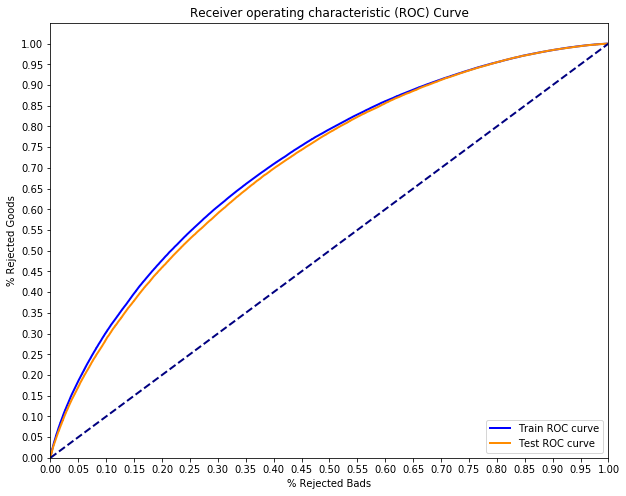

In [46]:
lr.fit(X_train, Y_train)
rocurve(lr, X_train, X_test, Y_train, Y_test)

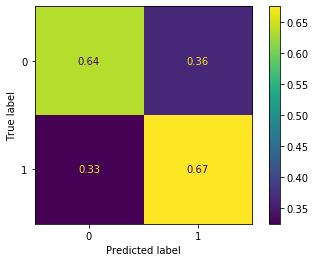

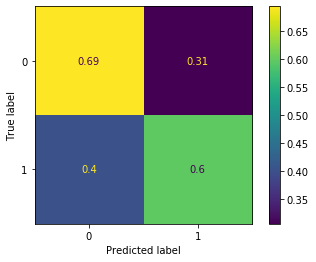

In [47]:
Y_train_pred = lr.predict(X_train)

plot_confusion_matrix(lr, X_train, Y_train, normalize='true')
plot_confusion_matrix(lr, X_test, Y_test, normalize='true')

In [48]:
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Variable'], data = X_train.columns)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficient'] = np.transpose(lr.coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', lr.intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
display(summary_table)

,Variable,Coefficient
0,Intercept,-0.071
1,"loan_amnt_(499.999, 8675.0]",-0.173
2,"loan_amnt_(8675.0, 15000.0]",-0.020
3,"loan_amnt_(15000.0, 40000.0]",0.123
4,term_36.0,-0.320
5,term_60.0,0.250
6,"int_rate_(5.308, 7.39]",-0.324
7,"int_rate_(7.39, 12.74]",0.064
8,"int_rate_(12.74, 30.99]",0.190
9,grade_A,-0.503
